# Setup

In [1]:
!pip install -U -q kaggle

In [2]:
from google.colab import files
from IPython.display import clear_output, display, Markdown, Pretty

In [3]:
files.upload()
clear_output()

In [4]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c AI4Code

100% 713M/714M [00:32<00:00, 22.7MB/s]
100% 714M/714M [00:32<00:00, 23.1MB/s]


In [6]:
!unzip AI4Code.zip && rm -rf AI4Code.zip
clear_output()

In [34]:
import os
import json
import random
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from joblib import delayed, Parallel
from nltk.corpus import stopwords
from termcolor import colored
from tqdm.auto import tqdm
from tqdm import notebook
from wordcloud import WordCloud

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
stop_words = set(stopwords.words('english'))

In [37]:
tqdm.pandas()

In [39]:
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)

In [12]:
pd.options.display.width = 180
pd.options.display.max_colwidth = 120

# Load data

In [13]:
def read_notebook(path: Path) -> pd.DataFrame:
    """
    Reads a directory of Jupyter notebooks,
    stored in JSON format, into a dataframe.

    Parameters:
        path: Path

    Returns:
        pd.DataFrame
    """
    return pd.read_json(
        path, dtype={'cell_type': 'category', 'source': 'str'}
        ).assign(id=path.stem).rename_axis('cell_id')

In [14]:
paths_train = list(Path('train').glob('*.json'))
paths_test = list(Path('test').glob('*.json'))

In [15]:
notebooks_train = Parallel()(
    delayed(read_notebook)(path)
    for path in notebook.tqdm(paths_train, desc='Train NBs')
    )

notebooks_test = Parallel()(
    delayed(read_notebook)(path)
    for path in notebook.tqdm(paths_test, desc='Test NBs')
    )

Train NBs:   0%|          | 0/139256 [00:00<?, ?it/s]

Test NBs:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
df_train = pd.concat(notebooks_train).set_index(
    'id', append=True
    ).swaplevel().sort_index(level='id', sort_remaining=False)

df_test = pd.concat(notebooks_test).set_index(
    'id', append=True
    ).swaplevel().sort_index(level='id', sort_remaining=False)

In [17]:
df_train

cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
00001756c60be8 1862f0a6      code  # This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
               2a9e43d6      code  import numpy as np\nimport pandas as pd\nimport random\n\nfrom sklearn.model_selection import train_test_split, cros...
               038b763d      code                                                                       import warnings\nwarnings.filterwarnings('ignore')
               2eefe0ef      code                                                                            matplotlib.rcParams.update({'font.size': 14})
               0beab1cd      code  def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):\n    print("Train R2:\...
...                           ...                                                                                                                      ...
fffe1d764579d5 0d770d6b  markdown                                                                                                 ## REMOVING THE OUTLIERS
               d45ddc62  markdown                                                                                                ### DIMENSIONALITY CURSE 
               1a63248d  markdown                                                                                      # BANGALORE HOUSE PRICE PREDICTION 
               a8ffc8b4  markdown       * We have achieved 75.2% accuracy in predicting the prices of the homes in Banglore using Decision Tree Regressor 
               4e2d4c2d  markdown                                                                                                       ## DATA INGESTION 

[6370646 rows x 2 columns]

In [18]:
!rm -rf train test

In [ ]:
df_train.to_csv('train.csv', index_label=['id', 'cell_id'])
df_test.to_csv('test.csv', index_label=['id', 'cell_id'])

In [ ]:
files.download('train.csv')
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df_train = pd.read_csv('train.csv', index_col=['id', 'cell_id'])
# df_test = pd.read_csv('test.csv', index_col=['id', 'cell_id'])

In [19]:
df_orders = pd.read_csv(
    'train_orders.csv', index_col='id', squeeze=True
    ).str.split()

# Helper functions

In [20]:
def display_markdown(markdown: str) -> None:
    """
    Displays a markdown cell.

    Parameters:
        markdown: str

    Returns:
        None
    """
    display(Markdown(markdown))

In [21]:
display_markdown('_Now we can display Markdown cells!_')

_Now we can display Markdown cells!_

In [22]:
def display_code(code: str) -> None:
    """
    Displays a code cell.

    Parameters:
        code: str

    Returns:
        None
    """
    display(Pretty(colored(code, 'white', 'on_magenta')))

In [23]:
def display_notebook(
    nb_id: str, ordered: bool = False, render_markdown: bool = True
    ) -> None:
    """
    Displays the contents of a notebook by its id, ordered or not.

    Parameters:
        nb_id: str
        ordered: bool = False
        render_markdown: bool = True

    Returns:
        None
    """
    notebook = df_train.loc[nb_id, :]

    if ordered:
        notebook = notebook.loc[df_orders.loc[nb_id], :]

    for _, row in notebook.iterrows():
        if render_markdown and row['cell_type'] == 'markdown':
            display_markdown(row['source'])
        else:
            display_code(row['source'])

# Exploratory data analysis

## Dataset

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6370646 entries, ('00001756c60be8', '1862f0a6') to ('fffe1d764579d5', '4e2d4c2d')
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   cell_type  object
 1   source     object
dtypes: object(2)
memory usage: 328.5+ MB


In [25]:
df_train.describe()

,cell_type,source
count,6370646,6370646
unique,2,4860715
top,code,df.head()
freq,4204582,15103


The most frequent cell contains a single line of code – `df.head()`.

In [26]:
display_markdown(
    f'''**Observations:**

    * The train set contains {df_train.index.levshape[0]} notebooks;
    * The test set contains {df_test.index.levshape[0]} notebooks;
    * For scoring, the test set will be replaced with a hidden test set;
    * The train set contains {df_train.index.levshape[1]} cells;
    * There are two types of cells – code and markdown.'''
)

**Observations:**

    * The train set contains 139256 notebooks;
    * The test set contains 4 notebooks;
    * For scoring, the test set will be replaced with a hidden test set;
    * The train set contains 6365854 cells;
    * There are two types of cells – code and markdown.

In [27]:
df_code = df_train[df_train['cell_type'] == 'code']
df_markdown = df_train[df_train['cell_type'] == 'markdown']

In [28]:
display_markdown(
    f'The train set contains **{len(df_code)} code cells** \
    and **{len(df_markdown)} markdown cells**.'
    )

The train set contains **4204582 code cells**     and **2166064 markdown cells**.

In [29]:
figure = go.Figure(data=[go.Pie(
    labels=['Code Cells', 'Markdown Cells'],
    values=[len(df_code), len(df_markdown)],
    pull=[0.1, 0],
    marker={'colors': ['red', 'blue'], 'line': {'color': 'gray', 'width': 2}}
    )])

figure.show()

Let's show the random notebook.

In [30]:
nb_id = random.choice(df_train.index.unique('id'))
print(f'Notebook:{nb_id}\nThe disordered notebook:\n')
display_notebook(nb_id)

Notebook:359ede70dd0731
The disordered notebook:



# !pip -qq install pandas==1.1.3
# !pip -qq install numpy==1.18.5
# !pip -qq install holidays==0.10.3
# !pip -qq install fbprophet==0.7.1
# !pip -qq install matplotlib==3.2.1
# !pip -qq install ipython==7.13.0
!pip -qq install pmdarima==1.8.0

import holidays
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from IPython.display import display
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)

df = pd.read_csv('../input/bitgrit-2/train_2.csv').drop(columns='Unnamed: 0')

df['send_timestamp'] = df.send_timestamp.apply(pd.to_datetime)
df['date'] = df.send_timestamp.apply(lambda x: x.date())
df = df.groupby(['shipping_company', 'date']).shipment_id.nunique().reset_index().sort_values(by=['shipping_company', 'date']).copy()
df['ds'] = df.date.apply(pd.to_datetime)

## Give zero value to the missing dates
min_date = df.ds.min()
max_date = df.ds.max()

idx = pd.date_range(min_date, max_date)

df1 = df[df.shipping_company=='SC1'].set_index('ds', drop=True).reindex(idx).fillna(0).reset_index().copy() ## time-series shiiping company 1
df2 = df[df.shipping_company=='SC2'].set_index('ds', drop=True).reindex(idx).fillna(0).reset_index().copy() ## time-series shiiping company 2
df3 = df[df.shipping_company=='SC3'].set_index('ds', drop=True).reindex(idx).fillna(0).reset_index().copy() ## time-series shiiping company 3

val1 = pd.DataFrame()
val1['ds'] = pd.date_range('2020-06-14', '2020-08-13')
val1['SC'] = 1
val2 = pd.DataFrame()
val2['ds'] = pd.date_range('2020-06-14', '2020-08-13')
val2['SC'] = 2
val3 = pd.DataFrame()
val3['ds'] = pd.date_range('2020-06-14', '2020-08-13')
val3['SC'] = 3

uk_holidays = set(holidays.UnitedKingdom(years = [2019,2020]).keys())

def seasonalities(dd):
    train = 'ds' not in dd.columns
    if train:
        dd['ds'] = dd['index']
        dd['y'] = dd.shipment_id
    dd['dow'] = dd.ds.apply(lambda x: x.dayofweek) ## day of week
    dd['dom'] = dd.ds.apply(lambda x: x.day)       ## day of month
    dd['weekend'] = dd.dow.isin([5,6])*1.0         ## is weekend
    dd['wom'] = (dd.dom-1)//7                      ## week of month
    dd['holiday'] = dd.ds.isin(uk_holidays)        ## is a UK holiday
    dd['year'] = dd.ds.apply(lambda x: x.year)     ## year
    dd['month'] = dd.ds.apply(lambda x: x.month)   ## month
    dd['week'] = dd.ds.apply(lambda x: x.week)     ## week of the year
    dd['half'] = (dd.dom-1)//15                    ## first half or second half of the month
    
    return dd

df1 = seasonalities(df1).dropna()
df2 = seasonalities(df2).dropna()
df3 = seasonalities(df3).dropna()

val1 = seasonalities(val1).dropna()
val2 = seasonalities(val2).dropna()
val3 = seasonalities(val3).dropna()

## mean of item count in first half and second half values

h1 = df1.groupby(['year', 'half' , 'month']).y.mean().reset_index()
h1['ds'] = h1.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
h2 = df2.groupby(['year', 'half' , 'month']).y.mean().reset_index()
h2['ds'] = h2.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
h3 = df3.groupby(['year', 'half' , 'month']).y.mean().reset_index()
h3['ds'] = h3.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)

vh1 = val1.groupby(['year', 'half' , 'month']).dow.count().reset_index().drop(columns='dow')
vh1['ds'] = vh1.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
vh2 = val2.groupby(['year', 'half' , 'month']).dow.count().reset_index().drop(columns='dow')
vh2['ds'] = vh2.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
vh3 = val3.groupby(['year', 'half' , 'month']).dow.count().reset_index().drop(columns='dow')
vh3['ds'] = vh3.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)

def model0(features,m='prophet', ys=True, ws=True):
    pred = []
    date = []
    sc = []

    a = 0
    for train0, val0 in zip([h1, h2, h3], [vh1, vh2, vh3]):
        train = train0.copy()
        val = val0.copy()
        
        if m=='prophet':
            model = Prophet(yearly_seasonality=ys, weekly_seasonality=ws)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
            
        if m=='arima':
            model = auto_arima(y=train.y, exogenous=train[features])
            pred += list(pd.DataFrame({'yhat':model.predict(n_periods=len(val), exogenous=val[features])}).yhat.apply(lambda x: int(max(x,0))).values)
            
        date += list(val.ds.values)
        a += 1
        sc += [a]*len(val)

    h_ = pd.DataFrame()
    h_['pred'] = pred
    h_['date'] = date
    h_['SC'] = sc
    h_ = h_.sort_values(by=['date', 'SC']).

h = pd.DataFrame()
h['pred_prophet1'], h['date'], h['SC'] = model0(["month"], 'prophet', False, False)
h['pred_prophet2'], _, _ = model0(["month"], 'prophet', True, False)
h['pred_prophet3'], _, _ = model0([], 'prophet', True, False)
h['pred_arima1'], _, _ = model0(["month"], 'arima')

def d_15_pred(x):
    if x.SC==1:
        return 1.64 + x.pred_prophet1 * (-0.67) + x.pred_prophet2 * (-0.47) + x.pred_prophet3 * (-0.5) + x.pred_arima1 * (0.0)
    if x.SC==2:
        return 5.01 + x.pred_prophet1 * (0.0) + x.pred_prophet2 * (-0.37) + x.pred_prophet3 * (-0.37) + x.pred_arima1 * (0.0)
    if x.SC==3:
        return 5.29 + x.pred_prophet1 * (0.0) + x.pred_prophet2 * (-0.19) + x.pred_prophet3 * (-0.19) + x.pred_arima1 * (-0.58)

h['pred'] = h.apply(d_15_pred, axis=1)

## Total in week

def seasonalities2(dd):
    dd['dom'] = dd.ds.apply(lambda x: x.day)
    dd['wom'] = (dd.dom-1)//7
    dd['year'] = dd.ds.apply(lambda x: x.year)
    dd['month'] = dd.ds.apply(lambda x: x.month)
    return dd

w1 = df1.groupby(['year', 'week']).y.sum().reset_index()
w1['ds'] = pd.to_datetime(w1.week.astype(str)+w1.year.astype(str).add('-1') ,format='%V%G-%u')
w2 = df2.groupby(['year', 'week']).y.sum().reset_index()
w2['ds'] = pd.to_datetime(w2.week.astype(str)+w2.year.astype(str).add('-1') ,format='%V%G-%u')
w3 = df3.groupby(['year', 'week']).y.sum().reset_index()
w3['ds'] = pd.to_datetime(w3.week.astype(str)+w3.year.astype(str).add('-1') ,format='%V%G-%u')

vw1 = val1.groupby(['year', 'week']).dow.count().reset_index().drop(columns='dow')
vw1['ds'] = pd.to_datetime(vw1.week.astype(str)+vw1.year.astype(str).add('-1') ,format='%V%G-%u')
vw2 = val2.groupby(['year', 'week']).dow.count().reset_index().drop(columns='dow')
vw2['ds'] = pd.to_datetime(vw2.week.astype(str)+vw2.year.astype(str).add('-1') ,format='%V%G-%u')
vw3 = val3.groupby(['year', 'week']).dow.count().reset_index().drop(columns='dow')
vw3['ds'] = pd.to_datetime(vw3.week.astype(str)+vw3.year.astype(str).add('-1') ,format='%V%G-%u')

w1, w2, w3, vw1, vw2, vw3 = seasonalities2(w1), seasonalities2(w2), seasonalities2(w3), seasonalities2(vw1), seasonalities2(vw2), seasonalities2(vw3)

def model1(features,m='prophet', ys=True, ws=True):
    pred = []
    date = []
    sc = []
    a = 0
    for c,(train0, val0) in enumerate(zip([w1, w2, w3], [vw1, vw2, vw3])):
        c = c+1
        train = train0.copy()
        val = val0.copy()
        if m=='prophet':
            model = Prophet(yearly_seasonality=ys, weekly_seasonality=ws)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
        if m=='arima':
            if len(features)!=0:
                model = auto_arima(y=train.y, exogenous=train[features])
                pred += list(pd.DataFrame({'yhat':model.predict(n_periods=len(val), exogenous=val[features])}).yhat.apply(lambda x: int(max(x,0))).values)
            if len(features)==0:
                model = auto_arima(y=train.y)
                pred += list(pd.DataFrame({'yhat':model.predict(n_periods=len(val))}).yhat.ap

def model2(features, ys=True, ws=True):
    pred = []
    date = []
    sc = []
    a = 0
    for train0, val0 in zip([w1, w2, w3], [vw1, vw2, vw3]):
        a += 1
        for i in train0.wom.unique():
            train = train0[train0.wom==i].copy()
            val = val0[val0.wom==i].copy()
            model = Prophet(yearly_seasonality=ys, weekly_seasonality=ws)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
            date += list(val.ds.values)
            sc += [a]*len(val)
    w_ = pd.DataFrame()
    w_['pred'] = pred
    w_['date'] = date
    w_['SC'] = sc
    w_ = w_.sort_values(by=['date', 'SC']).reset_index(drop=True)
    
    return w_.pred.values, w_.date.values, w_.SC.values

w = pd.DataFrame()
w['pred_prophet1'], w['date'], w['SC'] = model1(["wom"], 'prophet', False, False)
w['pred_prophet2'], _, _ = model2(["wom"], False, False)
w['pred_prophet3'], _, _ = model2([], False, False)
w['pred_prophet4'], _, _ = model1([], 'prophet', False, False)
w['pred_arima1'], _, _ = model1(["wom", "month"], 'arima')
w['pred_arima2'], _, _ = model1([], 'arima')
w['pred_arima3'], _, _ = model1(["wom"], 'arima')
w['pred_arima4'], _, _ = model1(["wom", 'year'], 'arima')
w['pred_arima5'], _, _ = model1(["wom", 'year', 'dom'], 'arima')

def fn(x):
    if x.SC==1:
        return x.pred_prophet1*1.802 + x.pred_prophet2*6.768 - x.pred_prophet3*6.403 + x.pred_prophet4*4.591 - x.pred_arima1*10.309 + x.pred_arima2*19.540 - x.pred_arima3*10.589 + x.pred_arima4*2.998 + x.pred_arima5*3.046 - 113.197
    if x.SC==2:
        return x.pred_prophet1*(-6.532) - x.pred_prophet2*0.101 - x.pred_prophet3*0.101 + x.pred_prophet4*0.0 + x.pred_arima1*9.825 + x.pred_arima2*7.980 + x.pred_arima3*3.217 - x.pred_arima4*8.368 - x.pred_arima5*2.045 - 62.273
    if x.SC==3:
        return x.pred_prophet1*0.613 + x.pred_prophet2*0.884 + x.pred_prophet3*0.884 - x.pred_prophet4*4.629 - x.pred_arima1*2.439 - x.pred_arima2*8.145 + x.pred_arima3*9.024 - x.pred_arima4*9.512 - x.pred_arima5*1.408 + 397.067

w['pred'] = w.apply(fn, axis=1)

h['year'] = h.date.apply(lambda x: pd.to_datetime(x).year)
h['month'] = h.date.apply(lambda x: pd.to_datetime(x).month)
h['half'] = h.date.apply(lambda x: (pd.to_datetime(x).day-1)//15)

h1['avg_15'] = h1.y
h2['avg_15'] = h2.y
h3['avg_15'] = h3.y

df1 = df1.merge(h1[['year', 'month', 'half', 'avg_15']], on=['year', 'month', 'half'], how='left').dropna()
df2 = df2.merge(h2[['year', 'month', 'half', 'avg_15']], on=['year', 'month', 'half'], how='left').dropna()
df3 = df3.merge(h3[['year', 'month', 'half', 'avg_15']], on=['year', 'month', 'half'], how='left').dropna()

h['avg_15'] = h.pred

val1 = val1.merge(h[['SC', 'year', 'month', 'half', 'avg_15']], on=['SC', 'year', 'month', 'half'])
val2 = val2.merge(h[['SC', 'year', 'month', 'half', 'avg_15']], on=['SC', 'year', 'month', 'half'])
val3 = val3.merge(h[['SC', 'year', 'month', 'half', 'avg_15']], on=['SC', 'year', 'month', 'half'])

w['year'] = w.date.apply(lambda x: pd.to_datetime(x).year)
w['week'] = w.date.apply(lambda x: pd.to_datetime(x).week)

w1['wk_sum'] = w1.y
w2['wk_sum'] = w2.y
w3['wk_sum'] = w3.y

df1 = df1.merge(w1[['year', 'week', 'wk_sum']], on=['year', 'week'], how='left').dropna()
df2 = df2.merge(w2[['year', 'week', 'wk_sum']], on=['year', 'week'], how='left').dropna()
df3 = df3.merge(w3[['year', 'week', 'wk_sum']], on=['year', 'week'], how='left').dropna()

w['wk_sum'] = w.pred

val1 = val1.merge(w[['SC', 'year', 'week', 'wk_sum']], on=['SC', 'year', 'week'])
val2 = val2.merge(w[['SC', 'year', 'week', 'wk_sum']], on=['SC', 'year', 'week'])
val3 = val3.merge(w[['SC', 'year', 'week', 'wk_sum']], on=['SC', 'year', 'week'])

def model_p1(features, b1=True, b2=True):
    pred=[]
    date=[]
    sc=[]
    for c, (train0, val0) in enumerate(zip([df1, df2, df3], [val1, val2, val3])):
        c = c+1
        for i in train0.dow.unique():
            train = train0[(train0.dow==i)].copy()
            val = val0[val0.dow==i].copy()
            model = Prophet(yearly_seasonality=b1, weekly_seasonality=b2)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
            date += list(val.ds.values)
            sc += list(val.SC.values)
            
    d1 = pd.DataFrame()
    d1['pred'] = pred
    d1['date'] = date
    d1['SC'] = sc
    d1 = d1.sort_values(by=['date', 'SC']).reset_index(drop=True)
    
    return list(d1.pred.values)
    
def model_p2(features, b1=True, b2=True):
    pred=[]
    date=[]
    sc=[]
    for c, (train0, val0) in enumerate(zip([df1, df2, df3], [va

d = pd.DataFrame()
d['date'] = list(val1.ds.values)+list(val2.ds.values)+list(val3.ds.values)
d['SC'] = list(val1.SC.values)+list(val2.SC.values)+list(val3.SC.values) 
d = d.sort_values(by=['date', 'SC']).reset_index(drop=True)

d['pred_p_0'] = model_p1(['avg_15', 'wk_sum'], True, True)
d['pred_p_1'] = model_p1(['avg_15', 'wk_sum'], True, False)
d['pred_p_2'] = model_p1(['avg_15', 'wk_sum'], False, True)
d['pred_p_3'] = model_p1(['avg_15', 'wk_sum'], False, False)
d['pred_p_4'] = model_p2(['avg_15', 'wk_sum'], True, True)
d['pred_p_5'] = model_p2(['avg_15', 'wk_sum'], True, False)

def fn(x):
    if x.SC==1:
        return x.pred_p_0 * (0.062) + x.pred_p_1 * (0.062) + x.pred_p_2 * (0.138) + x.pred_p_3 * (0.138) + x.pred_p_4 * (0.21) + x.pred_p_5 * (0.455) + 0.27
    if x.SC==2:
        return x.pred_p_0 * (2.177) + x.pred_p_1 * (-1.712) + x.pred_p_2 * (0.04) + x.pred_p_3 * (0.04) + x.pred_p_4 * (-0.487) + x.pred_p_5 * (0.97) + 0.61
    if x.SC==3:
        return x.pred_p_0 * (0.05) + x.pred_p_1 * (0.05) + x.pred_p_2 * (-3.638) + x.pred_p_3 * (3.781) + x.pred_p_4 * (0.438) + x.pred_p_5 * (0.142) + 0.85

d['pred']=d.apply(fn, axis=1)
d.pred.to_csv('submission_2.csv', header=False, index=False)

pd.read_csv('submission_2.csv', header=None)

# Step 5: Predicting weekly statistics

### Models for predicting 15 day mean

### Models for day level predictions

### Models for predicting weekly total

# Step 3: Add seasonalities and other features

# Step 2: Dummy Test file to add date regressors

### Combining Predictions

# Step 1: Generate the required time series

# Day level Predictions

# Initialize Environment

### Combining Predictions

# Step 4: Predicting 15 day Statistics

## Adding new features to dataframe

The same notebook, but ordered.

In [31]:
print(f'Notebook:{nb_id}\nThe ordered notebook:\n')
display_notebook(nb_id, ordered=True)

Notebook:359ede70dd0731
The ordered notebook:



# Initialize Environment

# !pip -qq install pandas==1.1.3
# !pip -qq install numpy==1.18.5
# !pip -qq install holidays==0.10.3
# !pip -qq install fbprophet==0.7.1
# !pip -qq install matplotlib==3.2.1
# !pip -qq install ipython==7.13.0
!pip -qq install pmdarima==1.8.0

import holidays
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from IPython.display import display
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)

# Step 1: Generate the required time series

df = pd.read_csv('../input/bitgrit-2/train_2.csv').drop(columns='Unnamed: 0')

df['send_timestamp'] = df.send_timestamp.apply(pd.to_datetime)
df['date'] = df.send_timestamp.apply(lambda x: x.date())
df = df.groupby(['shipping_company', 'date']).shipment_id.nunique().reset_index().sort_values(by=['shipping_company', 'date']).copy()
df['ds'] = df.date.apply(pd.to_datetime)

## Give zero value to the missing dates
min_date = df.ds.min()
max_date = df.ds.max()

idx = pd.date_range(min_date, max_date)

df1 = df[df.shipping_company=='SC1'].set_index('ds', drop=True).reindex(idx).fillna(0).reset_index().copy() ## time-series shiiping company 1
df2 = df[df.shipping_company=='SC2'].set_index('ds', drop=True).reindex(idx).fillna(0).reset_index().copy() ## time-series shiiping company 2
df3 = df[df.shipping_company=='SC3'].set_index('ds', drop=True).reindex(idx).fillna(0).reset_index().copy() ## time-series shiiping company 3

# Step 2: Dummy Test file to add date regressors

val1 = pd.DataFrame()
val1['ds'] = pd.date_range('2020-06-14', '2020-08-13')
val1['SC'] = 1
val2 = pd.DataFrame()
val2['ds'] = pd.date_range('2020-06-14', '2020-08-13')
val2['SC'] = 2
val3 = pd.DataFrame()
val3['ds'] = pd.date_range('2020-06-14', '2020-08-13')
val3['SC'] = 3

# Step 3: Add seasonalities and other features

uk_holidays = set(holidays.UnitedKingdom(years = [2019,2020]).keys())

def seasonalities(dd):
    train = 'ds' not in dd.columns
    if train:
        dd['ds'] = dd['index']
        dd['y'] = dd.shipment_id
    dd['dow'] = dd.ds.apply(lambda x: x.dayofweek) ## day of week
    dd['dom'] = dd.ds.apply(lambda x: x.day)       ## day of month
    dd['weekend'] = dd.dow.isin([5,6])*1.0         ## is weekend
    dd['wom'] = (dd.dom-1)//7                      ## week of month
    dd['holiday'] = dd.ds.isin(uk_holidays)        ## is a UK holiday
    dd['year'] = dd.ds.apply(lambda x: x.year)     ## year
    dd['month'] = dd.ds.apply(lambda x: x.month)   ## month
    dd['week'] = dd.ds.apply(lambda x: x.week)     ## week of the year
    dd['half'] = (dd.dom-1)//15                    ## first half or second half of the month
    
    return dd

df1 = seasonalities(df1).dropna()
df2 = seasonalities(df2).dropna()
df3 = seasonalities(df3).dropna()

val1 = seasonalities(val1).dropna()
val2 = seasonalities(val2).dropna()
val3 = seasonalities(val3).dropna()

# Step 4: Predicting 15 day Statistics

## mean of item count in first half and second half values

h1 = df1.groupby(['year', 'half' , 'month']).y.mean().reset_index()
h1['ds'] = h1.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
h2 = df2.groupby(['year', 'half' , 'month']).y.mean().reset_index()
h2['ds'] = h2.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
h3 = df3.groupby(['year', 'half' , 'month']).y.mean().reset_index()
h3['ds'] = h3.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)

vh1 = val1.groupby(['year', 'half' , 'month']).dow.count().reset_index().drop(columns='dow')
vh1['ds'] = vh1.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
vh2 = val2.groupby(['year', 'half' , 'month']).dow.count().reset_index().drop(columns='dow')
vh2['ds'] = vh2.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)
vh3 = val3.groupby(['year', 'half' , 'month']).dow.count().reset_index().drop(columns='dow')
vh3['ds'] = vh3.apply(lambda x: pd.to_datetime(str(int(x.year))+'-'+str(int(x.month))+'-'+str(int(x.half*15+1))), axis=1)

### Models for predicting 15 day mean

def model0(features,m='prophet', ys=True, ws=True):
    pred = []
    date = []
    sc = []

    a = 0
    for train0, val0 in zip([h1, h2, h3], [vh1, vh2, vh3]):
        train = train0.copy()
        val = val0.copy()
        
        if m=='prophet':
            model = Prophet(yearly_seasonality=ys, weekly_seasonality=ws)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
            
        if m=='arima':
            model = auto_arima(y=train.y, exogenous=train[features])
            pred += list(pd.DataFrame({'yhat':model.predict(n_periods=len(val), exogenous=val[features])}).yhat.apply(lambda x: int(max(x,0))).values)
            
        date += list(val.ds.values)
        a += 1
        sc += [a]*len(val)

    h_ = pd.DataFrame()
    h_['pred'] = pred
    h_['date'] = date
    h_['SC'] = sc
    h_ = h_.sort_values(by=['date', 'SC']).

h = pd.DataFrame()
h['pred_prophet1'], h['date'], h['SC'] = model0(["month"], 'prophet', False, False)
h['pred_prophet2'], _, _ = model0(["month"], 'prophet', True, False)
h['pred_prophet3'], _, _ = model0([], 'prophet', True, False)
h['pred_arima1'], _, _ = model0(["month"], 'arima')

### Combining Predictions

def d_15_pred(x):
    if x.SC==1:
        return 1.64 + x.pred_prophet1 * (-0.67) + x.pred_prophet2 * (-0.47) + x.pred_prophet3 * (-0.5) + x.pred_arima1 * (0.0)
    if x.SC==2:
        return 5.01 + x.pred_prophet1 * (0.0) + x.pred_prophet2 * (-0.37) + x.pred_prophet3 * (-0.37) + x.pred_arima1 * (0.0)
    if x.SC==3:
        return 5.29 + x.pred_prophet1 * (0.0) + x.pred_prophet2 * (-0.19) + x.pred_prophet3 * (-0.19) + x.pred_arima1 * (-0.58)

h['pred'] = h.apply(d_15_pred, axis=1)

# Step 5: Predicting weekly statistics

## Total in week

def seasonalities2(dd):
    dd['dom'] = dd.ds.apply(lambda x: x.day)
    dd['wom'] = (dd.dom-1)//7
    dd['year'] = dd.ds.apply(lambda x: x.year)
    dd['month'] = dd.ds.apply(lambda x: x.month)
    return dd

w1 = df1.groupby(['year', 'week']).y.sum().reset_index()
w1['ds'] = pd.to_datetime(w1.week.astype(str)+w1.year.astype(str).add('-1') ,format='%V%G-%u')
w2 = df2.groupby(['year', 'week']).y.sum().reset_index()
w2['ds'] = pd.to_datetime(w2.week.astype(str)+w2.year.astype(str).add('-1') ,format='%V%G-%u')
w3 = df3.groupby(['year', 'week']).y.sum().reset_index()
w3['ds'] = pd.to_datetime(w3.week.astype(str)+w3.year.astype(str).add('-1') ,format='%V%G-%u')

vw1 = val1.groupby(['year', 'week']).dow.count().reset_index().drop(columns='dow')
vw1['ds'] = pd.to_datetime(vw1.week.astype(str)+vw1.year.astype(str).add('-1') ,format='%V%G-%u')
vw2 = val2.groupby(['year', 'week']).dow.count().reset_index().drop(columns='dow')
vw2['ds'] = pd.to_datetime(vw2.week.astype(str)+vw2.year.astype(str).add('-1') ,format='%V%G-%u')
vw3 = val3.groupby(['year', 'week']).dow.count().reset_index().drop(columns='dow')
vw3['ds'] = pd.to_datetime(vw3.week.astype(str)+vw3.year.astype(str).add('-1') ,format='%V%G-%u')

w1, w2, w3, vw1, vw2, vw3 = seasonalities2(w1), seasonalities2(w2), seasonalities2(w3), seasonalities2(vw1), seasonalities2(vw2), seasonalities2(vw3)

### Models for predicting weekly total

def model1(features,m='prophet', ys=True, ws=True):
    pred = []
    date = []
    sc = []
    a = 0
    for c,(train0, val0) in enumerate(zip([w1, w2, w3], [vw1, vw2, vw3])):
        c = c+1
        train = train0.copy()
        val = val0.copy()
        if m=='prophet':
            model = Prophet(yearly_seasonality=ys, weekly_seasonality=ws)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
        if m=='arima':
            if len(features)!=0:
                model = auto_arima(y=train.y, exogenous=train[features])
                pred += list(pd.DataFrame({'yhat':model.predict(n_periods=len(val), exogenous=val[features])}).yhat.apply(lambda x: int(max(x,0))).values)
            if len(features)==0:
                model = auto_arima(y=train.y)
                pred += list(pd.DataFrame({'yhat':model.predict(n_periods=len(val))}).yhat.ap

def model2(features, ys=True, ws=True):
    pred = []
    date = []
    sc = []
    a = 0
    for train0, val0 in zip([w1, w2, w3], [vw1, vw2, vw3]):
        a += 1
        for i in train0.wom.unique():
            train = train0[train0.wom==i].copy()
            val = val0[val0.wom==i].copy()
            model = Prophet(yearly_seasonality=ys, weekly_seasonality=ws)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
            date += list(val.ds.values)
            sc += [a]*len(val)
    w_ = pd.DataFrame()
    w_['pred'] = pred
    w_['date'] = date
    w_['SC'] = sc
    w_ = w_.sort_values(by=['date', 'SC']).reset_index(drop=True)
    
    return w_.pred.values, w_.date.values, w_.SC.values

w = pd.DataFrame()
w['pred_prophet1'], w['date'], w['SC'] = model1(["wom"], 'prophet', False, False)
w['pred_prophet2'], _, _ = model2(["wom"], False, False)
w['pred_prophet3'], _, _ = model2([], False, False)
w['pred_prophet4'], _, _ = model1([], 'prophet', False, False)
w['pred_arima1'], _, _ = model1(["wom", "month"], 'arima')
w['pred_arima2'], _, _ = model1([], 'arima')
w['pred_arima3'], _, _ = model1(["wom"], 'arima')
w['pred_arima4'], _, _ = model1(["wom", 'year'], 'arima')
w['pred_arima5'], _, _ = model1(["wom", 'year', 'dom'], 'arima')

### Combining Predictions

def fn(x):
    if x.SC==1:
        return x.pred_prophet1*1.802 + x.pred_prophet2*6.768 - x.pred_prophet3*6.403 + x.pred_prophet4*4.591 - x.pred_arima1*10.309 + x.pred_arima2*19.540 - x.pred_arima3*10.589 + x.pred_arima4*2.998 + x.pred_arima5*3.046 - 113.197
    if x.SC==2:
        return x.pred_prophet1*(-6.532) - x.pred_prophet2*0.101 - x.pred_prophet3*0.101 + x.pred_prophet4*0.0 + x.pred_arima1*9.825 + x.pred_arima2*7.980 + x.pred_arima3*3.217 - x.pred_arima4*8.368 - x.pred_arima5*2.045 - 62.273
    if x.SC==3:
        return x.pred_prophet1*0.613 + x.pred_prophet2*0.884 + x.pred_prophet3*0.884 - x.pred_prophet4*4.629 - x.pred_arima1*2.439 - x.pred_arima2*8.145 + x.pred_arima3*9.024 - x.pred_arima4*9.512 - x.pred_arima5*1.408 + 397.067

w['pred'] = w.apply(fn, axis=1)

## Adding new features to dataframe

h['year'] = h.date.apply(lambda x: pd.to_datetime(x).year)
h['month'] = h.date.apply(lambda x: pd.to_datetime(x).month)
h['half'] = h.date.apply(lambda x: (pd.to_datetime(x).day-1)//15)

h1['avg_15'] = h1.y
h2['avg_15'] = h2.y
h3['avg_15'] = h3.y

df1 = df1.merge(h1[['year', 'month', 'half', 'avg_15']], on=['year', 'month', 'half'], how='left').dropna()
df2 = df2.merge(h2[['year', 'month', 'half', 'avg_15']], on=['year', 'month', 'half'], how='left').dropna()
df3 = df3.merge(h3[['year', 'month', 'half', 'avg_15']], on=['year', 'month', 'half'], how='left').dropna()

h['avg_15'] = h.pred

val1 = val1.merge(h[['SC', 'year', 'month', 'half', 'avg_15']], on=['SC', 'year', 'month', 'half'])
val2 = val2.merge(h[['SC', 'year', 'month', 'half', 'avg_15']], on=['SC', 'year', 'month', 'half'])
val3 = val3.merge(h[['SC', 'year', 'month', 'half', 'avg_15']], on=['SC', 'year', 'month', 'half'])

w['year'] = w.date.apply(lambda x: pd.to_datetime(x).year)
w['week'] = w.date.apply(lambda x: pd.to_datetime(x).week)

w1['wk_sum'] = w1.y
w2['wk_sum'] = w2.y
w3['wk_sum'] = w3.y

df1 = df1.merge(w1[['year', 'week', 'wk_sum']], on=['year', 'week'], how='left').dropna()
df2 = df2.merge(w2[['year', 'week', 'wk_sum']], on=['year', 'week'], how='left').dropna()
df3 = df3.merge(w3[['year', 'week', 'wk_sum']], on=['year', 'week'], how='left').dropna()

w['wk_sum'] = w.pred

val1 = val1.merge(w[['SC', 'year', 'week', 'wk_sum']], on=['SC', 'year', 'week'])
val2 = val2.merge(w[['SC', 'year', 'week', 'wk_sum']], on=['SC', 'year', 'week'])
val3 = val3.merge(w[['SC', 'year', 'week', 'wk_sum']], on=['SC', 'year', 'week'])

# Day level Predictions

### Models for day level predictions

def model_p1(features, b1=True, b2=True):
    pred=[]
    date=[]
    sc=[]
    for c, (train0, val0) in enumerate(zip([df1, df2, df3], [val1, val2, val3])):
        c = c+1
        for i in train0.dow.unique():
            train = train0[(train0.dow==i)].copy()
            val = val0[val0.dow==i].copy()
            model = Prophet(yearly_seasonality=b1, weekly_seasonality=b2)
            for feat in features:
                model.add_regressor(feat)
            model.fit(train)
            pred += list(model.predict(val)['yhat'].apply(lambda x: int(max(x,0))).values)
            date += list(val.ds.values)
            sc += list(val.SC.values)
            
    d1 = pd.DataFrame()
    d1['pred'] = pred
    d1['date'] = date
    d1['SC'] = sc
    d1 = d1.sort_values(by=['date', 'SC']).reset_index(drop=True)
    
    return list(d1.pred.values)
    
def model_p2(features, b1=True, b2=True):
    pred=[]
    date=[]
    sc=[]
    for c, (train0, val0) in enumerate(zip([df1, df2, df3], [va

d = pd.DataFrame()
d['date'] = list(val1.ds.values)+list(val2.ds.values)+list(val3.ds.values)
d['SC'] = list(val1.SC.values)+list(val2.SC.values)+list(val3.SC.values) 
d = d.sort_values(by=['date', 'SC']).reset_index(drop=True)

d['pred_p_0'] = model_p1(['avg_15', 'wk_sum'], True, True)
d['pred_p_1'] = model_p1(['avg_15', 'wk_sum'], True, False)
d['pred_p_2'] = model_p1(['avg_15', 'wk_sum'], False, True)
d['pred_p_3'] = model_p1(['avg_15', 'wk_sum'], False, False)
d['pred_p_4'] = model_p2(['avg_15', 'wk_sum'], True, True)
d['pred_p_5'] = model_p2(['avg_15', 'wk_sum'], True, False)

def fn(x):
    if x.SC==1:
        return x.pred_p_0 * (0.062) + x.pred_p_1 * (0.062) + x.pred_p_2 * (0.138) + x.pred_p_3 * (0.138) + x.pred_p_4 * (0.21) + x.pred_p_5 * (0.455) + 0.27
    if x.SC==2:
        return x.pred_p_0 * (2.177) + x.pred_p_1 * (-1.712) + x.pred_p_2 * (0.04) + x.pred_p_3 * (0.04) + x.pred_p_4 * (-0.487) + x.pred_p_5 * (0.97) + 0.61
    if x.SC==3:
        return x.pred_p_0 * (0.05) + x.pred_p_1 * (0.05) + x.pred_p_2 * (-3.638) + x.pred_p_3 * (3.781) + x.pred_p_4 * (0.438) + x.pred_p_5 * (0.142) + 0.85

d['pred']=d.apply(fn, axis=1)
d.pred.to_csv('submission_2.csv', header=False, index=False)

pd.read_csv('submission_2.csv', header=None)

## Code cells
Let's look at the example code cell.

In [32]:
display_code(random.choice(df_code['source']))

data.head()

Let's look at the words length of code cells.

In [33]:
code_lengths = np.array([len(cell.split()) for cell in df_code['source']])

In [41]:
display_markdown(
    f'''**Code cells length:**

    * Min: {min(code_lengths)}
    * Max: {max(code_lengths)}
    * Mean: {round(np.mean(code_lengths), 2)}
''')

**Code cells length:**

    * Min: 1
    * Max: 74589
    * Mean: 25.24


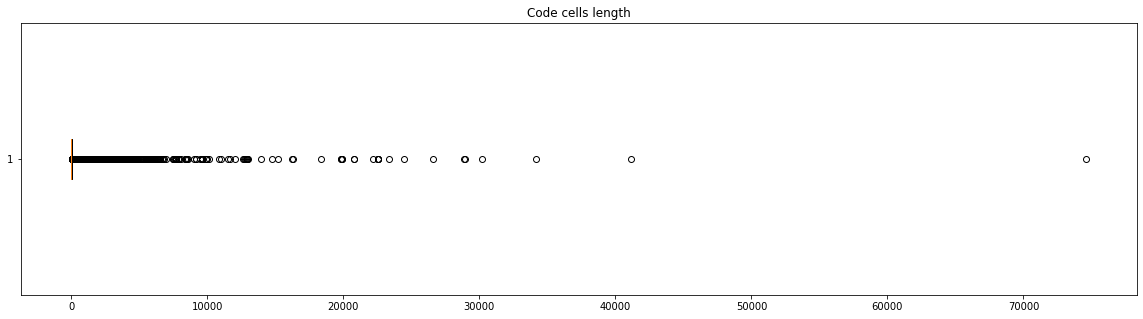

In [42]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.boxplot(code_lengths, vert=False)
plt.title('Code cells length')
plt.show()

Let's look at the most common words occuring in a randomly selected sample of 1000 code cells.

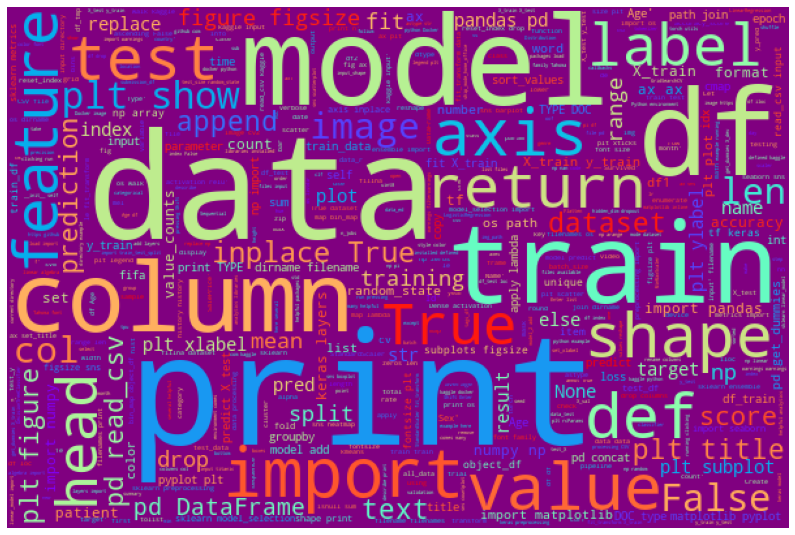

In [46]:
wordcloud = WordCloud(
    width=600, height=400, max_words=5000, stopwords=stop_words,
    background_color='purple', max_font_size=120, colormap='rainbow'
    ).generate(''.join(random.choices(df_code['source'], k=1000)))

fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

## Markdown cells
Let's look at the example markdown cell.

In [47]:
display_markdown(random.choice(df_markdown['source']))

Got a good accuracy but still can do much better

Let's look at the words length of markdown cells.

In [48]:
markdown_lengths = np.array(
    [len(cell.split()) for cell in df_markdown['source']]
    )

In [49]:
display_markdown(
    f'''**Markdown cells length:**

    * Min: {min(markdown_lengths)}
    * Max: {max(markdown_lengths)}
    * Mean: {round(np.mean(markdown_lengths), 2)}
''')

**Markdown cells length:**

    * Min: 1
    * Max: 38939
    * Mean: 29.42


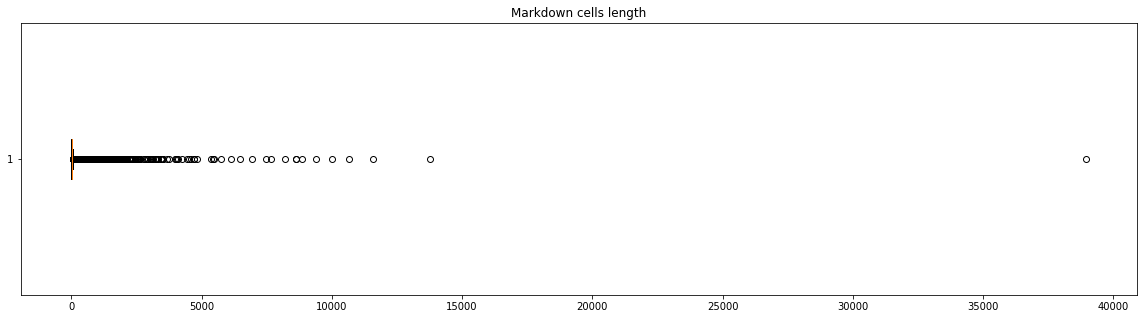

In [50]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.boxplot(markdown_lengths, vert=False)
plt.title('Markdown cells length')
plt.show()

Let's look at the most common words occuring in a randomly selected sample of 1000 markdown cells.

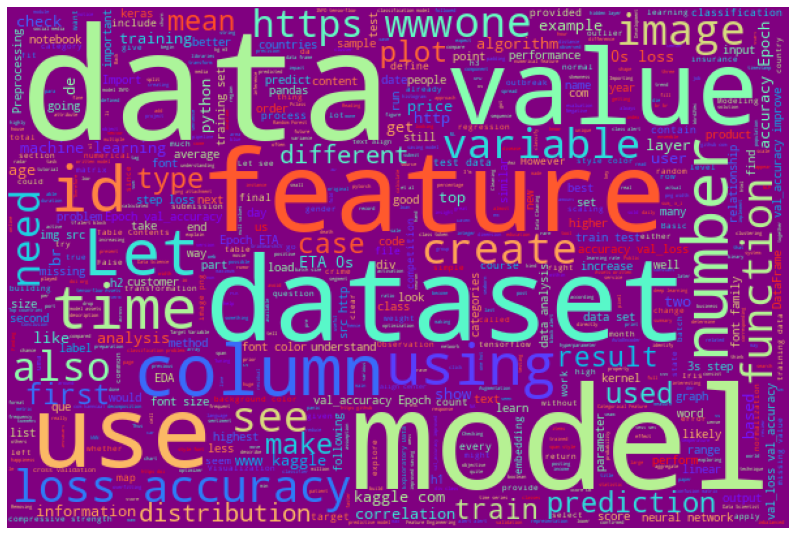

In [51]:
wordcloud = WordCloud(
    width=600, height=400, max_words=5000, stopwords=stop_words,
    background_color='purple', max_font_size=120, colormap='rainbow'
    ).generate(''.join(random.choices(df_markdown['source'], k=1000)))

fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)